# **Progetto Deblur**

---

Un'azienda vuole commercializzare un dispositivo di acquisizione immagini, del quale si sa che acquisisce con rumore Gaussiano additivo e sfocatura Gaussiana.
Il modello è quindi:

\begin{align*}
    b = A x_{true} + \eta
\end{align*}

Dove $A \in \mathbb{R}^{mn}$ è la matrice di sfocamento, $\eta \sim \mathcal{N}(0, \sigma^2)$ rumore additivo con varianza $\sigma^2$ incognita, $b \in \mathbb{R}^{mn}$ è la vettorizzazione dell'immagine corrotta (acquisita) $B \in \mathbb{R}^{m \times n}$, $x_{true} \in \mathbb{R}^{mn}$ è la vettorizzazione dell'immagine originale $X_{true} \in \mathbb{R}^{m \times n}$.


1. Dopo aver importato le librerie necessarie, assegnare ad una variabile $X$ l'immagine $\texttt{cameraman}$, ottenibile tramite la libreria $\texttt{skimage.data}$ con il nome di $\texttt{camera()}$, effettuarne il $\texttt{reshape}$ e assegnarlo alla variabile $x$.

2. Tramite la funzione $\texttt{skimage.filters.gaussian}$ aggiungere sfocatura Gaussiana ad $X$ per ottenere $X_{blur}$, che rappresenta il reshape ad immagine di $x_{blur} = A x_{true}$, con $A$ matrice di sfocatura.

3. Caricare su una variabile $\eta$, della stessa dimensione di $X_{true}$, una realizzazione di rumore gaussiano con varianza $\sigma = 0.1$ (fare riferimento alle slides per la formula). 
Utilizzare $\eta$ per corrompere l'immagine $X_{blur}$ e calcolare $B = X_{blur} + \eta$. \\
Visualizzare i risultati ottenuti.

In [53]:
from scipy.signal import convolve2d
from numpy import fft

import scipy.stats as st  

def gkern(kernlen, nsig):
  """
  Genera un kernel per la realizzazione di un filtro di sfocatura Gaussiana.

  Input ->
  kernlen: diametro della sfocatura gaussiana.
  nsig:    varianza della sfocatura. Più basso, più sfoca.

  Output -> Kernel Gaussiano di dimensione (kernlen+1) x (kernlen+1) e varianza nsig.
  """

  x = np.linspace(-nsig, nsig, kernlen+1)
  kern1d = np.diff(st.norm.cdf(x))
  kern2d = np.outer(kern1d, kern1d)
  return kern2d/kern2d.sum()

def A(x, d=7, sigma=0.5):
  """
  Esegue il prodotto Ax, dove A è la matrice di sfocamento (che, per aumentare l'efficienza, non viene memorizzata).
  
  Input ->
  x:     Immagine di dimensione m x n, che si vuole sfocare.
  d:     Diametro della sfocatura Gaussiana.
  sigma: Varianza della sfocatura Gaussiana.
  
  Output -> Immagine di dimensione m x n, sfocata.
  """
  m, n = x.shape

  K_ext = np.zeros((m, n))
  K = gkern(d, sigma)
  K_ext[:d, :d] = K
  K_ext = fft.fft2(K_ext)
  x = fft.fft2(x)

  return np.real(fft.ifft2(K_ext * x))

def AT(x, d=7, sigma=0.5):
  """
  Esegue il prodotto A^T x, dove A è la matrice di sfocamento (che, per aumentare l'efficienza, non viene memorizzata).
  
  Input ->
  x:     Immagine di dimensione m x n, che si vuole sfocare.
  d:     Diametro della sfocatura Gaussiana.
  sigma: Varianza della sfocatura Gaussiana.
  
  Output -> Immagine di dimensione m x n, sfocata.
  """
  
  m, n = x.shape

  K_ext = np.zeros((m, n))
  K_ext[:d, :d] = gkern(d, sigma)
  K_ext = fft.fft2(K_ext)
  x = fft.fft2(x)

  return np.real(fft.ifft2(np.conj(K_ext) * x))

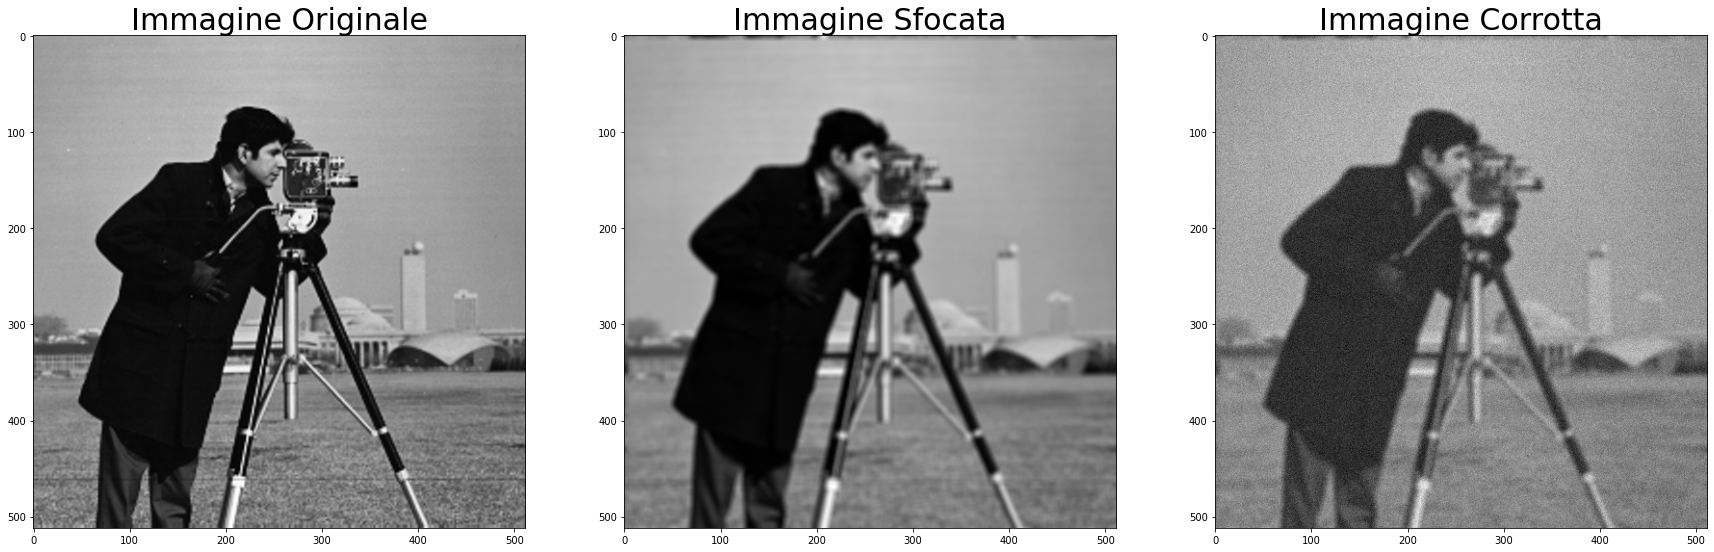

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, filters

# 1
X = data.camera()
m, n = X.shape
x = X.reshape(m*n)


# 2
X_blur = A(X)
x_blur = X_blur.reshape(m*n)


# 3
# Generiamo il rumore eta
sigma = 0.1 # Varianza del rumore
eta = np.random.normal(size=X_blur.shape)
eta /= np.linalg.norm(eta, 'fro')
eta *= sigma * np.linalg.norm(X_blur,'fro')

# Aggiungiamo il rumore all'immagine sfocata
B = X_blur + eta
b = B.reshape(m*n)

# Visualizziamo i risultati
plt.figure(figsize=(30, 10))

ax1 = plt.subplot(1, 3, 1)
ax1.imshow(X, cmap='gray')
plt.title('Immagine Originale', fontsize=30)

ax2 = plt.subplot(1, 3, 2)
ax2.imshow(X_blur, cmap='gray')
plt.title('Immagine Sfocata', fontsize=30)

ax3 = plt.subplot(1, 3, 3)
ax3.imshow(B, cmap='gray')
plt.title('Immagine Corrotta', fontsize=30)

plt.show()

Il problema di ricostruire l'immagine originale partendo dalla sua corruzione $b$, si può riscrivere come un problema di ottimizzazione

\begin{align}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 \hspace{2cm} (1)
\end{align}

4. Risolvere il problema (1) utilizzando l'algoritmo di discesa del gradiente con scelta del passo tramite backtracking, ricordando che, se 
\begin{align*}
  f(x) = \frac{1}{2} ||Ax - b||_2^2, \hspace{10px} \nabla f(x) = A^T(Ax - b)
\end{align*}
E chiamare la soluzione ottenuta $x_{naive}$.

5. Modificare l'algoritmo precedente a far restituire l'errore tra l'immagine ricostruita al passo $k$ e l'immagine originale, per ogni $k$. Visualizzare il grafico dell'errore, e individuare per quale valore di $k$ si ha semiconvergenza. Per tale valore, calcolare l'immagine ricostruita e chiamarla $x_{trunc}$.

In [58]:
def f(x, b):
  return 0.5 * (np.linalg.norm(A(x) - b)**2)

def grad_f(x, b):
  return AT(A(x) - b)


def next_step(x, b, f, grad):         #backtracking per calcolo passo
  alpha = 1.1
  rho = 0.5
  c1 = 0.25
  while f(x - alpha * grad, b) > f(x, b) - alpha * c1 * np.linalg.norm(np.dot(grad.T, grad)):
    alpha = alpha * rho
  return alpha


def minimize(x0, b, maxit, abstop):      #funzione che trova il minimo
  x = x0
  grad = grad_f(x, b)
  k = 0
  while(np.linalg.norm(grad) > abstop) and (k < maxit):
    x = x - next_step(x, b, f, grad) * grad
    grad = grad_f(x, b)
    k = k + 1

  return(x, grad, k)

In [59]:
MAXITERATIONS = 100
ABSOLUTE_STOP = 1.e-5
x0 = np.zeros(X.shape)
(x_naive, grad_naive, ite_naive) = minimize(x0, B, MAXITERATIONS, ABSOLUTE_STOP)


In [60]:
def minimize2(x0, x_true, b, maxit, abstop, f, grad_f):
  x = x0
  x_r = x0
  grad = grad_f(x, b)
  err = np.zeros(maxit)
  k = 0
  while(np.linalg.norm(grad) > abstop) and (k < maxit):
    x = x - next_step(x, b, f, grad) * grad
    grad = grad_f(x, b)
    err[k] = np.linalg.norm(x_true - x) 
    if(err[k] < err[k - 1]) and (k > 0):
      x_r = x
    k = k + 1
    
  err = err[0 : k] 
  return(x_r, grad, k, err)

  

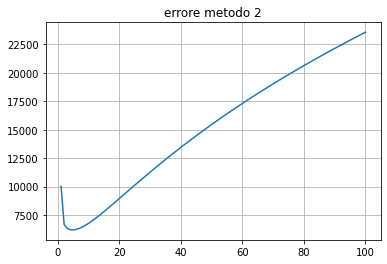

In [61]:
(x_tronc, grad_tronc, ite_tronc, errore) = minimize2(x0, X, B, MAXITERATIONS, ABSOLUTE_STOP, f, grad_f)

err_plot = np.linspace(1, ite_tronc, errore.size)
plt.plot(err_plot, errore)
plt.title('errore metodo 2')
plt.grid()
plt.show()


Text(0.5, 1.0, 'Immagine Troncata')

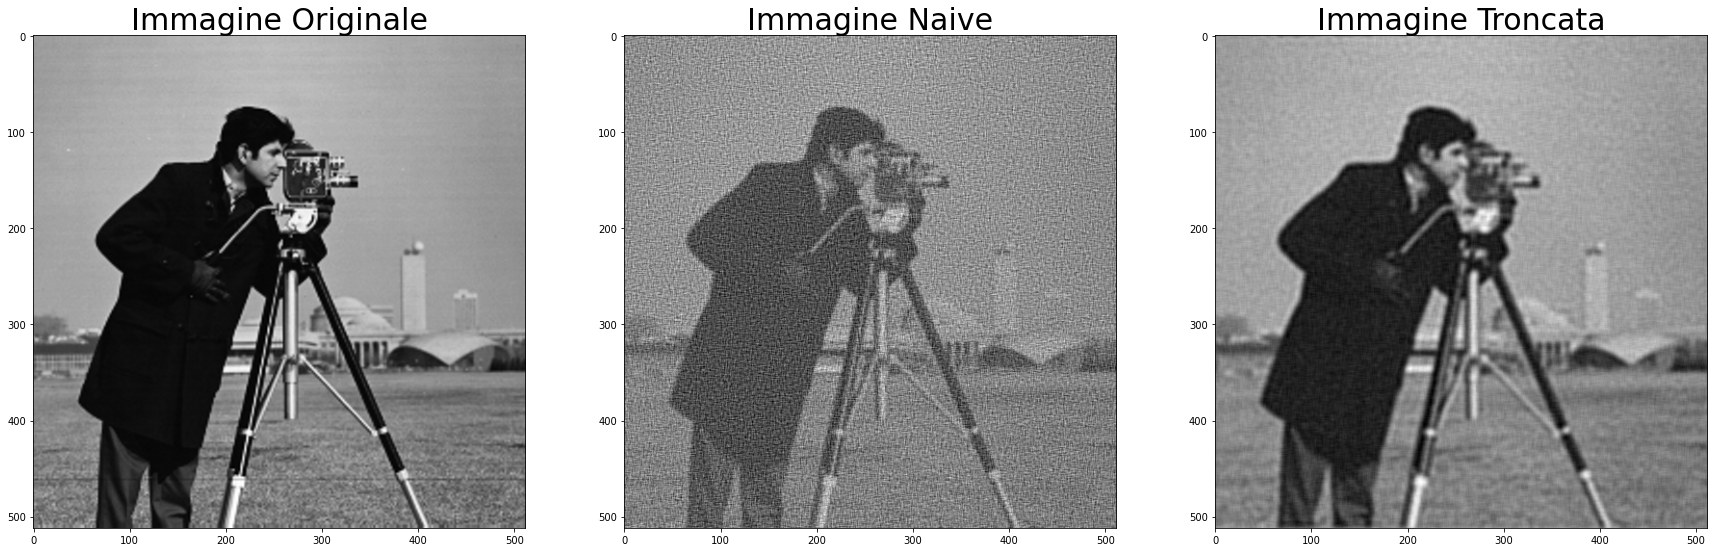

In [62]:
plt.figure(figsize=(30, 10))


ax1 = plt.subplot(1, 3, 1)
ax1.imshow(X, cmap='gray')
plt.title('Immagine Originale', fontsize=30)

ax2 = plt.subplot(1, 3, 2)
ax2.imshow(x_naive, cmap='gray')
plt.title('Immagine Naive', fontsize=30)

ax3 = plt.subplot(1, 3, 3)
ax3.imshow(x_tronc, cmap='gray')
plt.title('Immagine Troncata', fontsize=30)

Per risolvere la semiconvergenza, si introduce il problema regolarizzato

\begin{align*}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2 \hspace{2cm} (2)
\end{align*}

con $\lambda > 0$ parametro di regolarizzazione.

6. Sfruttando il fatto che, se
\begin{align*}
f(x) = \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2, \hspace{10px} \nabla f(x) = A^T(Ax - b) + \lambda x
\end{align*}
Risolvere il problema (2) utilizzando l'algoritmo precedente per diversi valori di $\lambda$, e stimare il valore ottimale di $\lambda$ che minimizzi l'errore tra l'immagine ricostruita e l'immagine originale (metodo euristico per il parametro di regolarizzazione). Chiamare $x_{\lambda}$ tale soluzione. \\

7. Stimare il valore ottimale di $\lambda$ tramite principio di discrepanza, ovvero scegliere il più grande $\lambda$ tale che
\begin{align*}
  ||A x_\lambda - b||_2^2 \leq ||\eta||_2^2
\end{align*}
Dove $\eta$ è il rumore. Chiamare $x_\lambda^{disc}$ la soluzione ottenuta dal $\lambda$ calcolato con principio di discrepanza.
 

In [63]:
def f_reg(x, b, lamb):
  return 0.5 * (np.linalg.norm(A(x) - b)**2) + (0.5 * lamb * np.linalg.norm(x)**2)

def gradf_reg(x, b, lamb):
  return AT(A(x) - b) + lamb * x


def next_step_reg(x, b, grad, lamb):
  alpha=1.1
  rho = 0.5
  c1 =0.25
  while (f_reg(x - alpha * grad, b, lamb) > (f_reg(x, b, lamb) - alpha * c1 * np.linalg.norm(np.dot(grad, grad)))):
    alpha = alpha * rho
  return alpha


def minimize_reg(lamb, x0, x_true, b, maxit, abstop):
  x = x0
  grad = gradf_reg(x, b, lamb)
  err = np.zeros(maxit)
  k = 0
  while(np.linalg.norm(grad) > abstop) and (k < maxit):
    x = x - next_step_reg(x, b, grad, lamb) * grad
    grad = gradf_reg(x, b, lamb)
    err[k] = np.linalg.norm(x_true - x) 
    k = k + 1
    
  err = err[0 : k] 
  return(x, grad, k, err) 

-25037.664702236652


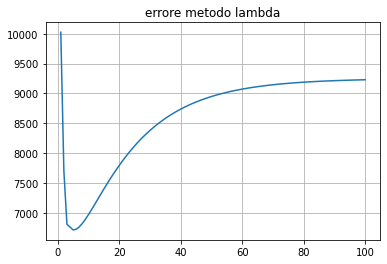

In [64]:
lamb = 0.0389
x0 = np.zeros(X.shape)
(x_disc, grad_disc, ite_disc, errore_disc) = minimize_reg(lamb, x0, X, B, MAXITERATIONS, ABSOLUTE_STOP)

print(np.linalg.norm(A(x_disc) - B)**2 - np.linalg.norm(eta)**2)

err2_plot = np.linspace(1, ite_disc, errore_disc.size)
plt.plot(err2_plot, errore_disc)
plt.title('errore metodo lambda')
plt.grid()
plt.show()


Text(0.5, 1.0, 'Immagine Lambda')

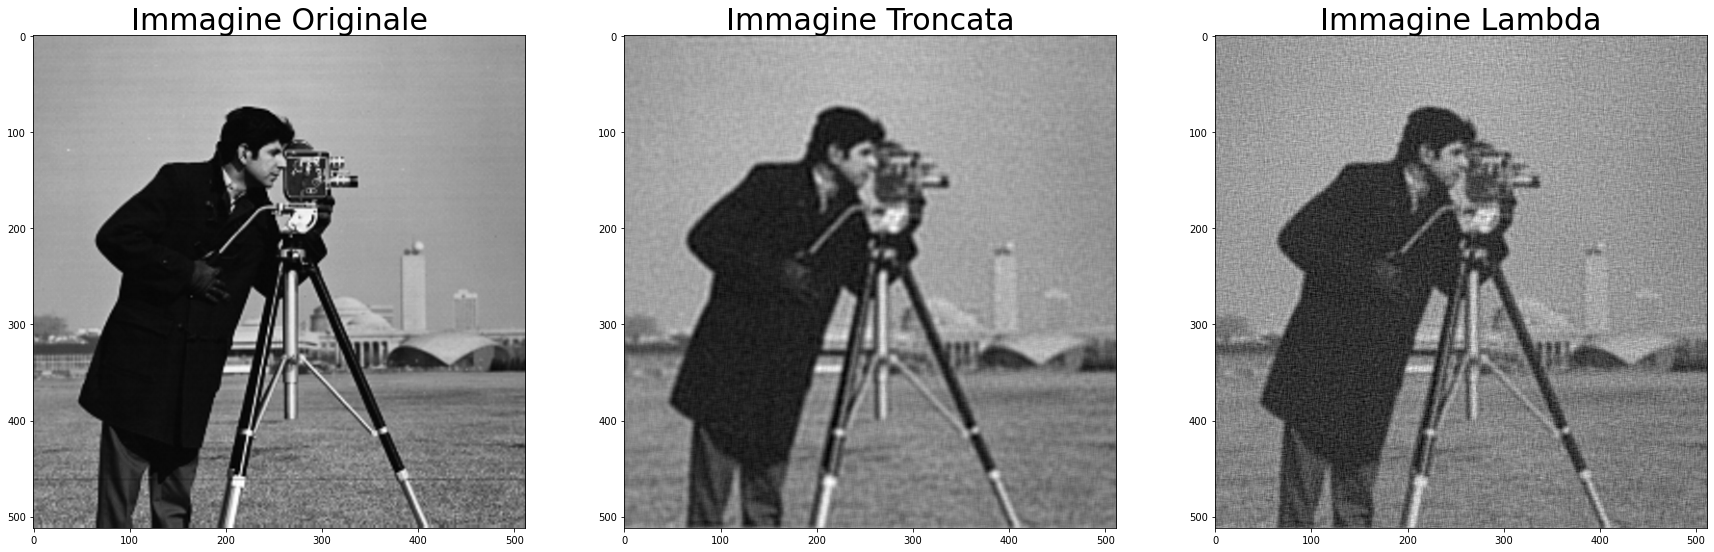

In [65]:
plt.figure(figsize=(30, 10))

ax1 = plt.subplot(1, 3, 1)
ax1.imshow(X, cmap='gray')
plt.title('Immagine Originale', fontsize=30)

ax2 = plt.subplot(1, 3, 2)
ax2.imshow(x_tronc, cmap='gray')
plt.title('Immagine Troncata', fontsize=30)

ax3 = plt.subplot(1, 3, 3)
ax3.imshow(x_disc, cmap='gray')
plt.title('Immagine Lambda', fontsize=30)

8. Ripetere quanto fatto nel punto 6, utilizzando la norma 1 come regolarizzatore, ovvero:
\begin{align*}
    x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \lambda ||x||_1 \hspace{2cm} (3)
\end{align*}
Dove la funzione obiettivo ha gradiente
\begin{align*}
  A^T(Ax - b) + \lambda \hspace{2px} sign(x)
\end{align*}

In [77]:
def f_norm1(x, b, lamb):                                                        #in questo esercizio c'è qualche problema
  return 0.5 * np.linalg.norm(A(x) - b)**2 + lamb * np.linalg.norm(x, 1)

def gradf_norm1(x, b, lamb):
  return AT(A(x)) - AT(b) + lamb * np.sign(x)

def next_step_norm1(x, b, grad, lamb):
  alpha=1.1
  rho = 0.5
  c1 =0.25
  while f_norm1(x - alpha * grad, b, lamb) > f_norm1(x, b, lamb) - alpha * c1 * np.linalg.norm(np.dot(grad.T, grad)):
    alpha = alpha * rho
  return alpha

def minimize_norm1(lamb, x0, x_true, b, maxit, abstop):
  x = x0
  grad = gradf_norm1(x, b, lamb)
  err = np.zeros(maxit)
  k = 0
  while np.linalg.norm(grad) > abstop and k < maxit:
    x = x - next_step_norm1(x, b, grad, lamb) * grad
    grad = gradf_norm1(x, b, lamb)
    err[k] = np.linalg.norm(x_true - x) 
    k = k + 1
    print("i")

  err = err[0 : k] 
  return(x, grad, k, err)

In [ ]:
x0 = np.zeros(X.shape)
lamb2 = 0.5
(x_lambda2, grad_lambda2, ite_lambda2, errore_lambda2) = minimize_norm1(lamb2, x0, X, B, MAXITERATIONS, ABSOLUTE_STOP)

print(np.linalg.norm(A(x_lambda2) - B)**2 - np.linalg.norm(eta)**2)

err3_plot = np.linspace(1, ite_lambda2, errore_lambda2.size)
plt.plot(err3_plot, errore_lambda2)
plt.title('errore metodo lambda norma 1')
plt.grid()
plt.show()

Text(0.5, 1.0, 'Immagine Lambda')

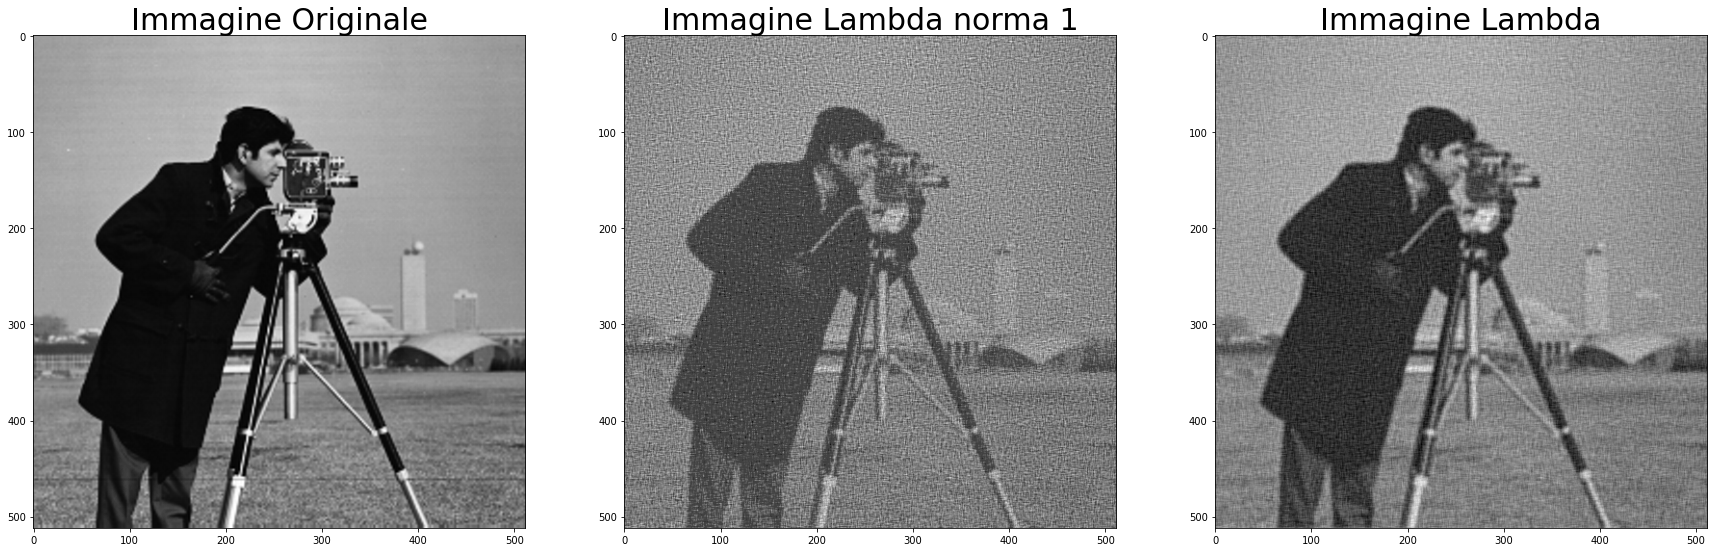

In [82]:
plt.figure(figsize=(30, 10))

ax1 = plt.subplot(1, 3, 1)
ax1.imshow(X, cmap='gray')
plt.title('Immagine Originale', fontsize=30)

ax2 = plt.subplot(1, 3, 2)
ax2.imshow(x_lambda2, cmap='gray')
plt.title('Immagine Lambda norma 1', fontsize=30)

ax3 = plt.subplot(1, 3, 3)
ax3.imshow(x_disc, cmap='gray')
plt.title('Immagine Lambda', fontsize=30)

9. ($\textit{facoltativo}$) Ripetere quanto fatto nei punti 6 e 8, utilizzando una norma mista come regolarizzatore, ovvero:
\begin{align*}
    x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2 + \mu ||x||_1 \hspace{2cm} (4)
\end{align*}

In [83]:
def f_mista(x, b, lamb, u):
  return 0.5 * (np.linalg.norm(A(x) - b)**2) + (0.5 * lamb * np.linalg.norm(x)**2) + u * np.linalg.norm(x, ord=1)

def gradf_mista(x, b, lamb, u):
  return AT(A(x) - b) + lamb * x + u * np.sign(x)


def next_step_mista(x, b, grad, lamb, u):
  alpha=1.1
  rho = 0.5
  c1 =0.25
  while (f_mista(x - alpha * grad, b, lamb, u) > (f_mista(x, b, lamb, u) - alpha * c1 * np.linalg.norm(np.dot(grad.T, grad)))):
    alpha = alpha * rho
  return alpha


def minimize_mista(lamb, u, x0, x_true, b, maxit, abstop):
  x = x0
  grad = gradf_mista(x, b, lamb, u)
  err = np.zeros(maxit)
  k = 0
  while(np.linalg.norm(grad) > abstop) and (k < maxit):
    x = x - next_step_mista(x, b, grad, lamb, u) * grad
    grad = gradf_mista(x, b, lamb, u)
    err[k] = np.linalg.norm(x_true - x) 
    k = k + 1
    
  err = err[0 : k] 
  return(x, grad, k, err)

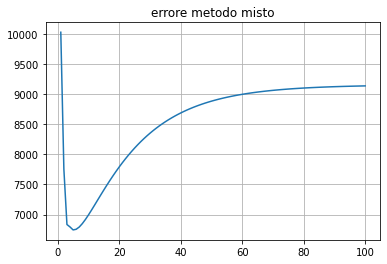

In [84]:
x0 = np.zeros(X.shape)
(x_mista, grad_mista, ite_mista, errore_mista) = minimize_mista(0.04, 0.01, x0, X, B, MAXITERATIONS, ABSOLUTE_STOP)


err4_plot = np.linspace(1, ite_mista, errore_mista.size)
plt.plot(err4_plot, errore_mista)
plt.title('errore metodo misto')
plt.grid()
plt.show()

Text(0.5, 1.0, 'Immagine Mista')

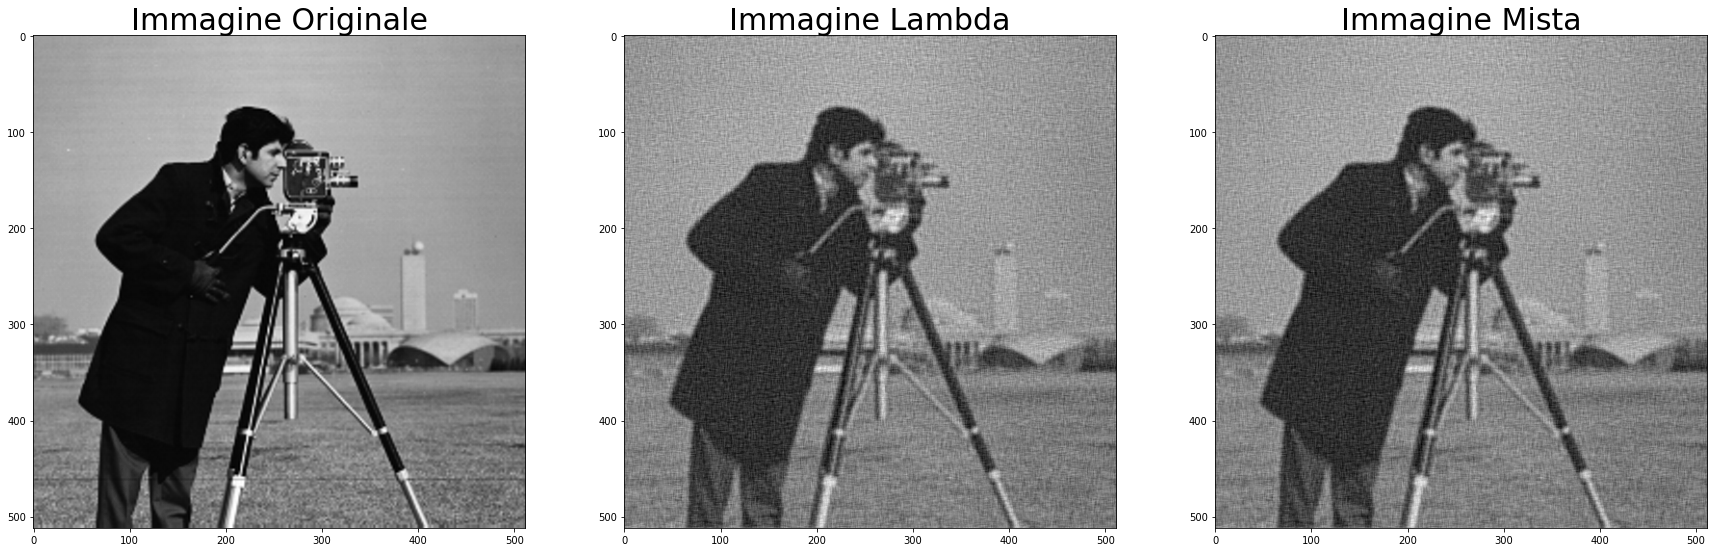

In [85]:
plt.figure(figsize=(30, 10))

ax1 = plt.subplot(1, 3, 1)
ax1.imshow(X, cmap='gray')
plt.title('Immagine Originale', fontsize=30)

ax2 = plt.subplot(1, 3, 2)
ax2.imshow(x_disc, cmap='gray')
plt.title('Immagine Lambda', fontsize=30)

ax3 = plt.subplot(1, 3, 3)
ax3.imshow(x_mista, cmap='gray')
plt.title('Immagine Mista', fontsize=30)

---

# Analisi dei risultati

---

Per ognuna delle soluzioni trovate, calcolare:

*   Errore relativo rispetto alla soluzione esatta $x_{true}$.
*   PSNR (Peak Signal to Noise Ratio).

Visualizzare le ricostruzioni ottenute con i vari metodi, e confrontare, sia numericamente che attraverso dei grafici, PSNR ed errore relativo ottenuti dalle ricostruzioni. Includere nel confronto, il valore delle metriche per l'immagine corrotta $b$.


Errore relativo metodo naive:  0.09059818475193954
Errore relativo metodo discrepanza:  0.13495391085420444
Errore relativo metodo norma 1:  0.32143202035512086
Errore relativo metodo misto:  0.13356762623468438
Errore relativo immagine corrotta:  0.2080638026365191


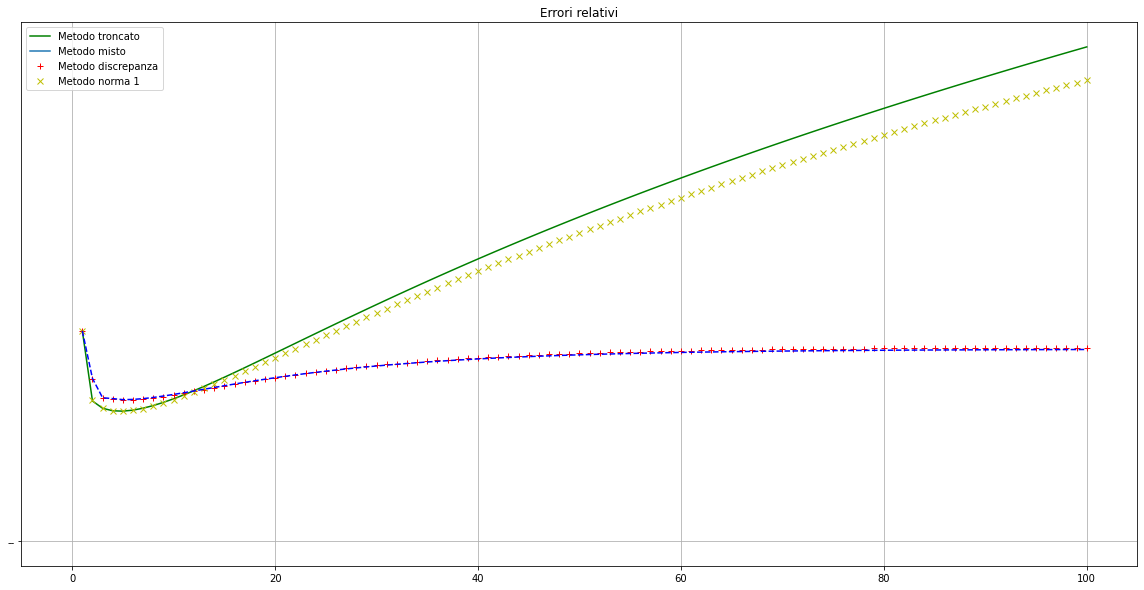

PSNR metodo 1:  80.47430360450443
PSNR metodo 2:  81.20709279521982
PSNR metodo 3:  84.03590539153899
PSNR metodo 4:  81.17254252627141
PSNR metodo immagine corrotta:  80.86199694323385


In [86]:
print("Errore relativo metodo naive: ", np.linalg.norm(X - x_tronc)/np.linalg.norm(X))
print("Errore relativo metodo discrepanza: ", np.linalg.norm(X - x_disc)/np.linalg.norm(X))
print("Errore relativo metodo norma 1: ", np.linalg.norm(X - x_lambda2)/np.linalg.norm(X))
print("Errore relativo metodo misto: ", np.linalg.norm(X - x_mista)/np.linalg.norm(X))
print("Errore relativo immagine corrotta: ", np.linalg.norm(X - B)/np.linalg.norm(X))

plt.figure(figsize=(20, 10))
err2_plot, errore_disc


plt.plot(err_plot, errore, 'green', '--')
plt.plot(err2_plot, errore_disc, 'r+')
plt.plot(err3_plot, errore_lambda2, 'yx')
plt.plot(err4_plot, errore_mista, 'b--' )
plt.legend(['Metodo troncato', 'Metodo misto', 'Metodo discrepanza', 'Metodo norma 1'], fontsize=10)
plt.title('Errori relativi')
plt.grid()
plt.show()

print("PSNR metodo 1: ", 20 * np.log10(np.max(x_tronc) / ((1 / x.size) * np.linalg.norm(eta))))
print("PSNR metodo 2: ", 20 * np.log10(np.max(x_disc) / ((1 / x.size) * np.linalg.norm(eta))))
print("PSNR metodo 3: ", 20 * np.log10(np.max(x_lambda2) / ((1 / x.size) * np.linalg.norm(eta))))
print("PSNR metodo 4: ", 20 * np.log10(np.max(x_mista) / ((1 / x.size) * np.linalg.norm(eta))))
print("PSNR metodo immagine corrotta: ", 20 * np.log10(np.max(B) / ((1 / x.size) * np.linalg.norm(eta))))

Ripetere tutti i passaggi, variando il livello del rumore (controllato dalla variabile $\sigma$), i parametri del kernel di sfocamento Gaussiano, e l'immagine di test. \\
Per la scelta delle immagini di test, utilizzare immagini **in bianco e nero, a scelta**, prese da internet, che rispettino i seguenti criteri:


*   Almeno un'immagine "geometrica", ovvero con pochi dettagli e contorni netti e ben contrastati (es. QRCode, Codice a Barre, Scacchiera...).
*   Almeno un'immagine "fotografica", ovvero con molti dettagli e livelli di grigio sfocati.
*   Almeno un'immagine contenente del testo, che diventerà difficilmente leggibile dopo il processo di sfocamento.


Osservare quale metodo di ricostruzione si comporta meglio nei vari esperimenti, ricordandosi corrompere l'immagine di input sia con rumore Gaussiano che con sfocatura.

